# 線形多クラス分類

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 多値分類とは

二値分類を拡張し、与えられた事例を３個以上のクラスに分類する多値分類を考える。多値分類の応用範囲は広く、世の中の様々なタスクが多値分類問題として取り組まれている。

以下はリアルタイム物体認識の例である。画像（動画）中の全てのピクセルに対して、人間、車、スノーボードなどの物体のクラスを予測することで、画像中に含まれる物体とその位置を認識できる。

<a href="http://www.youtube.com/watch?feature=player_embedded&v=1_SiUOYUoOI" title="YOLOv4 - The most accurate real-time neural network for object detection" target="_blank"><img src="http://img.youtube.com/vi/1_SiUOYUoOI/0.jpg" alt="YOLOv4 - The most accurate real-time neural network for object detection" /></a>

機械翻訳も多値分類問題の一種である。翻訳先言語の全ての単語を予測対象の「クラス」と見なす。翻訳元の文と、これまでに翻訳した単語列が与えられたとき、先頭から順に翻訳先言語の単語を分類タスクとして予測していくことで、翻訳文が得られる。

<img src="fig/mt.gif" width="320px" />

多値分類は我々の知らないところで使われていることもある。以下の例は、ツイートのプロフィールや投稿内容から、そのユーザの属性を推定する例である。推定された属性は広告の最適化や、マーケティングに用いられることがある。他にも、ニュースサイトなどのウェブサイトの閲覧履歴（どのようなページをクリックしているか）から訪問者の属性を推定し、その訪問者にとって最適な（クリック数が増えそうな）広告や記事を表示する（パーソナライゼーション）にも用いられる。

<img src="fig/attribute.svg" width="640px" />

## 手書き文字認識

今回は、[MNIST](http://yann.lecun.com/exdb/mnist/)をデータとして用い、手書き文字（数字）認識器を構築する。MNISTは手書きの数字70,000事例（訓練用に60,000事例、評価用に10,000事例）を収録したデータセットで、それぞれの事例は$28 \times 28$ピクセルのグレースケール画像と認識されるべき数字で表現される。手書き数字認識は、$28 \times 28 = 754$ピクセルの画素値が入力（説明変数）$\pmb{x}$として与えられたとき、認識されるべき数字（目的変数）$\hat{y}$を$10$クラス$\mathcal{Y} = \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\}$の中から選択する（分類する）タスクである。

<a title="Josef Steppan, CC BY-SA 4.0 &lt;https://creativecommons.org/licenses/by-sa/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"></a>

ここでは、[mnist.npzを作成するプログラム](#f6-99) でMNISTデータセットをNumPy形式に変換した"mnist.npz"を用いる。



---

## 【付録】  



<a id="f6-99"></a>
### mnist.npzを作成するプログラム  ：

MNISTデータセットを、"mnist.npz"：NumPy形式に変換  


In [2]:
import gzip
import sys
import struct
import urllib.request

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )


---

### 【補足】テンソルとは  

いったん「多次元データの集合体(配列)」で理解しておく  
なお、正確には「テンソル」と「多次元配列」は異なるとのこと  
  
![](./fig/tensor.jpg)  




---

【補足】生成された mnist.npz は、手作業で「mnist」フォルダへ移動済  


---
以下のプログラムで表示されるように、訓練データは$60,000$ (事例) $\times$ $28$ (高さ) $\times$ $28$ (幅) のテンソル（`data['train_x']`）と$60,000$ (事例) のベクトル（`data['train_y']`）、評価データは$10,000$ (事例) $\times$ $28$ (高さ) $\times$ $28$ (幅) のテンソル（`data['test_x']`）と$10,000$ (事例) のベクトル（`data['test_y']`）で構成される。


In [3]:
data = np.load('./mnist/mnist.npz')

print("Training data (X):", data['train_x'].shape, data['train_x'].dtype)
print("Training data (Y):", data['train_y'].shape, data['train_y'].dtype)
print("Test data (X):", data['test_x'].shape, data['test_x'].dtype)
print("Test data (Y):", data['test_y'].shape, data['test_y'].dtype)

Training data (X): (60000, 28, 28) float32
Training data (Y): (60000,) uint8
Test data (X): (10000, 28, 28) float32
Test data (Y): (10000,) uint8


以下のプログラムは学習データ中の$0$番目の事例の画像と、その正解の数字を表示する。$28 \times 28$ピクセルの画像は$28 \times 28$の行列として表現され、行列の各要素はピクセルの明るさ（輝度）を表す。公式サイトで配布されているデータセットでは輝度の値が$0$（暗い）から$255$（明るい）までの整数で表現されるが、"mnist.npz"では$0$（暗い）から$1$（明るい）の範囲になるように、各輝度値を$255$で割っている。

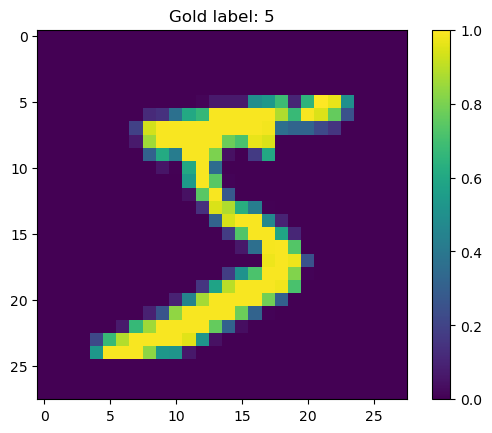

In [4]:
i = 0
x = data['train_x'][i]
y = data['train_y'][i]

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_title('Gold label: {}'.format(y))
im = ax.imshow(x)
fig.colorbar(im)
plt.show()

行列の要素にアクセスするときは、縦方向のインデックス→横方向のインデックスの順番になることに注意が必要である。以下は、左上から（0から）数えて下に$7$番目、右に$8$番目のピクセルの画素値にアクセスする例である。

In [5]:
x[7][8]

0.93333334


---

【補足】以下の文章：行・列の記載が誤っているように見えるため修正  
- 変更前：一番右まで到達したら一つ下の列に移動して同様の処理を繰り返す。  
- 変更後：一番右まで到達したら一つ下の行に移動して同様の処理を繰り返す。

---

二値分類では事例を$d$次元のベクトルで表現したが、手書き文字認識の事例は2次元の行列で表現されている。ここでは簡単のため、2次元の行列を平坦化し、1次元のベクトル$\pmb{x}$で事例を表現する。平坦化では、画像の上端の行で左から右に画素値をスキャンしていき、一番右まで到達したら一つ下の行に移動して同様の処理を繰り返す。これにより、左上から下に$b$ピクセル、右に$a$ピクセルの画素値は、平坦化されたベクトルの$(28b + a)$番目の要素に対応付けられる。さらに、平坦化されたベクトルの末尾に常に$1$となる要素を追加し、$d = 28 \times 28 + 1 = 785$次元のベクトルで画像を表現する。

以下のプログラムは複数の行列（画像）をまとめてベクトルに変換する。

In [6]:
def images_to_vectors(X):
    X = np.reshape(X, (len(X), -1))         # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]        # Append 1: (N x 784) -> (N x 785)

In [7]:
X_train = images_to_vectors(data['train_x'])
X_test = images_to_vectors(data['test_x'])

学習データ中の$0$番目の事例をベクトルに変換したものを可視化してみる。

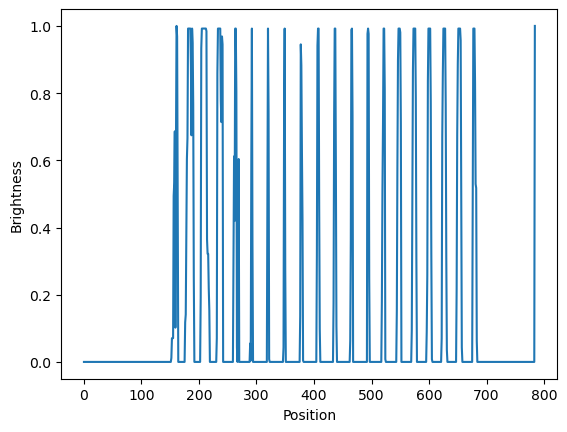

In [8]:
x = X_train[i]

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.plot(range(len(x)), x)
ax.set_xlabel('Position')
ax.set_ylabel('Brightness')
plt.show()

$(a,b)=(8,7)$の画素値は$28 \times 7 + 8 = 204$番目の要素として現れていることが確認できる。

In [9]:
x[204]

0.9333333373069763

2次元の画像を1次元のベクトルに変換してしまうのは乱暴に思われるかもしれないが、このような単純な取り扱いでも驚くほどうまくいく。

## 線形多クラス分類

---

### 【補足】

この後は難しい記載が多いので、以下だけ把握しておく  

- 画像データは「複数の行列」で構成されているが、1行にまとめる (= ベクトルに変換)  
  また、末尾に常に 1 となる要素 (「二値分類」と同じ役割のパラメタ) を追加  

- 判定結果：0～9、いずれかのクラスに分類  

- scikit-learnで学習(fit)、目的変数を最小化するパラメタ $\pmb{w}$ を算出  

- 評価データを使用して予測(predict)  
  → 評価データ$\pmb{x}$とパラメタ$\pmb{w}$ $\{\mathcal{C}_1, \mathcal{C}_2, \dots, \mathcal{C}_K\}$との内積を計算し、最も高い値のクラスに分類  


---

多クラス分類の入力と出力の表記を整理する。

+ 入力: 分類したい事例を表す$d$次元の特徴ベクトル $\pmb{x} \in \mathbb{R}^{d}$
+ クラス集合: 分類の候補となる$K$個のクラスの集合 $\mathcal{Y} = \{\mathcal{C}_1, \mathcal{C}_2, \dots, \mathcal{C}_K\}$
+ 出力: 入力を分類するのに最も適切なクラス $\hat{y} \in \mathcal{Y}$

MNISTによる手書き文字認識の場合、入力画像は$d=785$次元の特徴ベクトルで表され、予測したいクラスの集合は$\mathcal{Y} = \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\}$である。

**線形多クラス分類** (linear multi-class classification) では、各カテゴリ$y \in \mathcal{Y}$に重みベクトル$\pmb{w}_y \in \mathbb{R}^d$を用意し、事例$\pmb{x} \in \mathbb{R}^{d}$と重みベクトル$\pmb{w}_y$との内積を計算し、最も高い内積値が計算されたカテゴリ$y \in \mathcal{Y}$に分類する。


---

### 【ポイント】線形多クラス分類のラベル推定式  

<a id="f6-1"></a>
(6.1)  
\begin{align}
\hat{y} = \mathop{\rm argmax}\limits_{y \in \mathcal{Y}} \pmb{w}_y^\top\pmb{x}
\end{align}


---

数式では分かりづらいかもしれないので、手書き数字の画像が数字に分類されるまでの流れを以下の図で示す。分類したい画像が与えられると、先ほど説明した平坦化の処理を経て、特徴ベクトル$\pmb{x}$が作られる。線形多クラス分類のモデルは$y \in \mathcal{Y}$ごとに重みベクトル$\pmb{w}_y$を保有している。特徴ベクトル$\pmb{x}$と全てのクラスの重みベクトル$\pmb{w}_y$との内積を計算し、その最大値を求める。下の例では、$\pmb{w}_3 \cdot \pmb{x}$の内積値が最大であったので、$\hat{y} = 3$、つまり入力された画像の数字を$3$に分類した。

<img src="fig/linear-multi.png" alt="線形多クラス分類" width="75%" />


線形多クラス分類モデルのパラメータ$\pmb{w}_y$は、学習データによく合致するように（例えば学習データ上において文字認識が正しく行えるように）決定する。モデルのパラメータ$\pmb{w}_y$を推定する方法は様々あるが、ここでは多ロジスティック回帰に基づく確率的勾配降下法を紹介する。

## 多クラスロジスティック回帰

**多クラスロジスティック回帰**（multi-class logistic regression）は線形多クラス分類を実現するモデルの一つで、事例$\pmb{x}$をクラス$\mathcal{C}_j$に分類する条件付き確率$P(\hat{y}=\mathcal{C}_j|\pmb{x})$を以下の式で求める。


---

### 【ポイント】多クラスロジスティック回帰  

<a id="f6-2"></a>
(6.2)  
$$
\begin{align}
P(\hat{y} = \mathcal{C}_j|\pmb{x}) = \frac{\exp (\pmb{w}_j^\top\pmb{x})}{\sum_{k=1}^{K} \exp (\pmb{w}_k^\top\pmb{x})}
\end{align}
$$


---

この式を詳しく説明するため、あるクラス$\mathcal{C}_j$に対するモデルの重み$\pmb{w}_j$と事例$\pmb{x}$との内積を$a_j$

<a id="f6-3"></a>
(6.3)  
\begin{align}
a_j = \pmb{w}_j^\top\pmb{x}
\end{align}

と書くことにして、$K$個のクラスに対する内積値をベクトル$\pmb{a} \in \mathbb{R}^{K}$にまとめる。

<a id="f6-4"></a>
(6.4)  
\begin{align}
\pmb{a} = \begin{pmatrix}
a_1 \\ a_2 \\ \vdots \\ a_K
\end{pmatrix} = \begin{pmatrix}
\pmb{w}_1^\top\pmb{x} \\ \pmb{w}_2^\top\pmb{x} \\ \vdots \\ \pmb{w}_K^\top\pmb{x}
\end{pmatrix}
\end{align}

すると、式[(6.2)](#f6-2)は**ソフトマックス関数**（softmax function）$\sigma: \mathbb{R}^K \mapsto \mathbb{R}^K$で表すことができる。


---

### 【ポイント】ソフトマックス関数  

<a id="f6-5"></a>
(6.5)  
\begin{align}
P(\hat{y} = \mathcal{C}_j|\pmb{x}) = \sigma(\pmb{a})_j = \frac{\exp a_j}{\sum_{k = 1}^{K} \exp a_k}
\end{align}

ここで、$\sigma(\pmb{a})_j$はベクトル$\pmb{a}$にソフトマックス関数を適用して計算されたベクトルの$j$番目の要素を表す（$j \in \{1, 2, \dots, K\}$）。

シグモイド関数が一つの実数値のスコアを確率分布に変換したように、ソフトマックス関数は$K$個のスコア$a_1, a_2, \dots, a_K$を確率分布に変換する。二値分類におけるシグモイド関数は、多値分類におけるソフトマックス関数に対応付けられることから、両方の関数とも同じ記号$\sigma$で表記している。

ソフトマックス関数を実装すると以下のようになる。

In [10]:
def softmax(a):
    ea = np.exp(a)
    return ea / ea.sum()

以下のベクトルに対してソフトマックス関数を適用してみる。

In [11]:
a = np.array([0.1, -0.2, 0.3, -0.4, 0.5])
softmax(a)

array([0.19760595, 0.14639009, 0.24135645, 0.11985407, 0.29479344])

ソフトマックス関数への入力ベクトル、出力ベクトルを左右に並べて表示してみる。

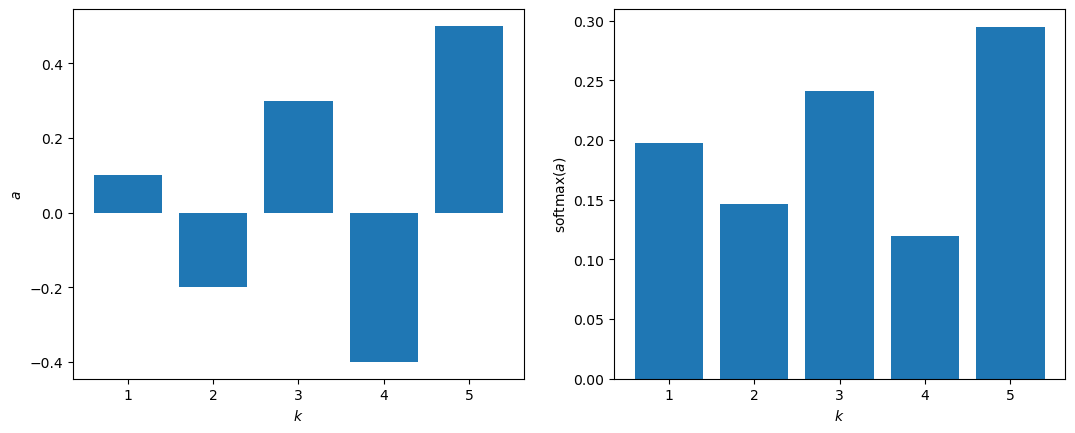

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
ax1.bar(range(1, 6), a)
ax1.set_xlabel('$k$')
ax1.set_ylabel('$a$')
ax2.bar(range(1, 6), softmax(a))
ax2.set_xlabel('$k$')
ax2.set_ylabel(r'${\rm softmax}(a)$')
fig.show()

多クラスロジスティック回帰は、重みベクトルを行列で表現することで、より一般的に記述できる。重みベクトル行ベクトルとし、$\pmb{w}_1^\top, \pmb{w}_2^\top, \dots, \pmb{w}_K^\top \in \mathbb{R}^d$を縦に並べた行列$\pmb{W} \in \mathbb{R}^{K \times d}$を考える。

<a id="f6-6"></a>
(6.6)  
\begin{align}
\pmb{W} = \begin{pmatrix}
\pmb{w}_1^\top \\ \pmb{w}_2^\top \\ \vdots \\ \pmb{w}_K^\top
\end{pmatrix}
\end{align}

すると、事例$\pmb{x} \in \mathbb{R}^d$全ての重みベクトル$\pmb{w}_k$との内積$a_k$は、

<a id="f6-7"></a>
(6.7)  
\begin{align}
\begin{pmatrix}a_1 \\ a_2 \\ \vdots \\ a_K\end{pmatrix} &= \begin{pmatrix}\pmb{w}_1^\top\pmb{x} \\ \pmb{w}_2^\top\pmb{x} \\ \vdots \\ \pmb{w}_K^\top\pmb{x}\end{pmatrix} \\
\pmb{a} &= \pmb{W}\pmb{x}
\end{align}

とまとめて書くことができる。

さらに、$\sigma(\pmb{a})_j$を$p_j$と略記することにして、ソフトマックス関数の適用結果をベクトル$\pmb{p} \in \mathbb{R}^K$で表すことにすると、

<a id="f6-8"></a>
(6.8)  
$$
\begin{align}
\begin{pmatrix}p_1 \\ p_2 \\ \vdots \\ p_K\end{pmatrix} &= \begin{pmatrix}\sigma(\pmb{W}\pmb{x})_1 \\ \sigma(\pmb{W}\pmb{x})_2 \\ \vdots \\ \sigma(\pmb{W}\pmb{x})_K\end{pmatrix} \\
\pmb{p} &= \sigma(\pmb{W}\pmb{x})
\end{align}
$$

すなわち、事例$\pmb{w}$を線形識別の重み行列$\pmb{W}$を用いて$K$個のクラスに分類するときの確率分布は、$\pmb{p} = \sigma(\pmb{W}\pmb{x})$という簡単な式で表すことができる。ここで、重み行列$\pmb{W} \in \mathbb{R}^{K \times d}$は、$d$次元の事例の空間$\mathbb{R}^d$を$K$個のクラスの空間$\mathbb{R}^K$に写像するものであると解釈できる。

これまでの定式化を手書き文字認識に当てはめた例を以下の図に示す。

<img src="fig/sigmoid.png" alt="多クラスロジスティック回帰" width="75%" />

## ソフトマックス関数の性質

定義から明らかなように、ソフトマックス関数は以下の性質を満たす。

<a id="f6-9"></a>
(6.9)  
\begin{gather}
\forall k: \sigma(\pmb{a})_k > 0
\end{gather}

<a id="f6-10"></a>
(6.10)  
\begin{gather}
\sum_{k = 1}^{K} \sigma(\pmb{a})_k = 1
\end{gather}

また、$K=2$の場合は、

<a id="f6-11"></a>
(6.11)  
\begin{align}
\sigma(\pmb{a})_1 = \frac{e^{a_1}}{\sum_{k = 1}^{2} e^{a_k}} = \frac{e^{a_1}}{e^{a_1} + e^{a_2}} = \frac{1}{1 + \frac{e^{a_2}}{e^{a_1}}} = \frac{1}{1 + e^{-(a_1 - a_2)}}
\end{align}

となることから、$(a_1 - a_2)$を入力としたシグモイド関数と等価であることが分かる。

### ソフトマックス関数の実装

例えば、$\pmb{a} = \begin{pmatrix}1000 & 0\end{pmatrix}$に対しては、$\sigma(\pmb{a}) \approx \begin{pmatrix}1 & 0\end{pmatrix}$となることが予想される。ところが、以下のプログラムを実行すると警告が表示され、正しい実行結果が得られない。

In [13]:
a = np.array([1000, 0])
softmax(a)

/tmp/ipykernel_627/1334177726.py:2: RuntimeWarning: overflow encountered in exp
  ea = np.exp(a)
/tmp/ipykernel_627/1334177726.py:3: RuntimeWarning: invalid value encountered in divide
  return ea / ea.sum()


array([nan,  0.])

これは、$e^{1000}$の計算でオーバーフローが発生するためである。この問題を回避するには、任意の実数$b \in \mathbb{R}$に対して、以下の関係が成り立つことを利用する。

<a id="f6-12"></a>
(6.12)  
\begin{align}
 \sigma(\pmb{a})_j
 &= \frac{\exp a_j}{\sum_{k = 1}^{K} \exp a_k} \\
 &= \frac{\exp (a_j - b + b)}{\sum_{k = 1}^{K} \exp (a_k - b + b)} \\
 &= \frac{\left(\exp (a_j - b) \right)\exp b}{\sum_{k = 1}^{K} \left(\exp (a_k - b)\right) \exp b} \\
 &= \frac{\exp (a_j - b)}{\sum_{k = 1}^{K} \exp (a_k - b)}
\end{align}

つまり、ソフトマックス関数の引数としてベクトル$\pmb{a}$を与える時、その全ての要素$a_k$から同じ定数を引いたベクトルでソフトマックス関数を適用しても、結果は変わらない。そこで、$\exp$の計算結果が大きくなりすぎないように、例えばベクトル$\pmb{a}$の要素の最大値を$b$として採用すればよい。

In [14]:
def softmax(a):
    ea = np.exp(a - np.max(a))
    return ea / ea.sum()

In [15]:
a = np.array([1000, 0])
softmax(a)

array([1., 0.])

### ソフトマックス関数の微分

多値分類モデルのパラメータ推定で必要になることを見越して、ここでソフトマックス関数の微分を示す。ソフトマックス関数$\sigma: \mathbb{R}^K \mapsto \mathbb{R}^K$を再掲する。

<a id="f6-13"></a>
(6.13)  
\begin{align}
\sigma(\pmb{a})_j = \frac{\exp a_j}{\sum_{k = 1}^{K} \exp a_k}
\end{align}

ここで、$\sigma(\pmb{a})_j$はベクトル$\pmb{a}$にソフトマックス関数を適用して計算されたベクトルの$j$番目の要素を表す。ソフトマックス関数が返すベクトルを陽に記述すると、

<a id="f6-14"></a>
(6.14)  
\begin{align}
\sigma(\pmb{a}) = \begin{pmatrix}
\frac{\exp a_1}{\sum_{k = 1}^{K} \exp a_k} \\ \vdots \\ \frac{\exp a_K}{\sum_{k = 1}^{K} \exp a_k}
\end{pmatrix}
\end{align}

となることから明らかなように、ソフトマックス関数の計算結果の$j$番目の要素$\sigma(\pmb{a})_j$は、入力されたベクトルの全ての要素の影響を受ける。したがって、

<a id="f6-15"></a>
(6.15)  
\begin{align}
\frac{\partial \sigma(\pmb{a})_1}{\partial a_1}, \frac{\partial \sigma(\pmb{a})_1}{\partial a_2}, \dots, \frac{\partial \sigma(\pmb{a})_1}{\partial a_K}, \frac{\partial \sigma(\pmb{a})_2}{\partial a_1}, \dots \frac{\partial \sigma(\pmb{a})_K}{\partial a_K}
\end{align}

の全てを求める必要がある。ソフトマックス関数が出力するベクトルのインデックス番号を$j \in \{1, 2, \dots, K\}$、ソフトマックス関数に入力するベクトルのインデックス番号を$h \in \{1, 2, \dots, K\}$として、ソフトマックス関数の偏微分$\frac{\partial \sigma(\pmb{a})_j}{\partial a_h}$を求める。


---

#### 【補足】商の微分法則  
$f(x) = \frac{g(x)}{h(x)}$と表されるとき、$g(x)$と$h(x)$がともに微分可能で、$h(x) \neq 0$ならば、
\begin{equation*}
f'(x) = \frac{g'(x)h(x) - g(x)h'(x)}{\{h(x)\}^2}
\end{equation*}


---

$h=j$のとき、

<a id="f6-16"></a>
(6.16)  
\begin{align}
\frac{\partial \sigma(\pmb{a})_j}{\partial a_j} &= \frac{\partial}{\partial a_j} \left(\frac{\exp a_j}{\sum_{k=1}^{K} \exp a_k}\right) \\
&= \frac{\frac{\partial}{\partial a_j} (\exp a_j) \cdot \left(\sum_{k=1}^{K} \exp a_k\right) - (\exp a_j)\cdot \frac{\partial}{\partial a_j}\left(\sum_{k=1}^{K} \exp a_k\right)}{\left(\sum_{k=1}^{K} \exp a_k\right)^2} \\
&= \frac{(\exp a_j) \cdot \left(\sum_{k=1}^{K} \exp a_k\right) - (\exp a_j)\cdot (\exp a_j)}{\left(\sum_{k=1}^{K} \exp a_k\right)^2} \\
&= \frac{(\exp a_j) \cdot \left(\sum_{k=1}^{K} \exp a_k\right)}{\left(\sum_{k=1}^{K} \exp a_k\right)^2} - \frac{(\exp a_j)^2}{\left(\sum_{k=1}^{K} \exp a_k\right)^2} \\
&= \frac{\exp a_j}{\sum_{k=1}^{K} \exp a_k} - \left(\frac{\exp a_j}{\sum_{k=1}^{K} \exp a_k} \right)^2 \\
&= \sigma(\pmb{a})_j - \left\{\sigma(\pmb{a})_j\right\}^2 \\
&= \sigma(\pmb{a})_j \left\{1 - \sigma(\pmb{a})_j\right\}
\end{align}

$h\neq j$のとき、

<a id="f6-17"></a>
(6.17)  
\begin{align}
\frac{\partial \sigma(\pmb{a})_j}{\partial a_h} &= \frac{\partial}{\partial a_h} \left(\frac{\exp a_j}{\sum_{k=1}^{K} \exp a_k}\right) \\
&= \frac{\frac{\partial}{\partial a_h} (\exp a_j) \cdot \left(\sum_{k=1}^{K} \exp a_k\right) - (\exp a_j)\cdot \frac{\partial}{\partial a_h}\left(\sum_{k=1}^{K} \exp a_k\right)}{\left(\sum_{k=1}^{K} \exp a_k\right)^2} \\
&= \frac{0 \cdot \left(\sum_{k=1}^{K} \exp a_k\right) - (\exp a_j)\cdot (\exp a_h)}{\left(\sum_{k=1}^{K} \exp a_k\right)^2} \\
&= -\frac{(\exp a_j) \cdot (\exp a_h)}{\left(\sum_{k=1}^{K} \exp a_k\right)^2} \\
&= -\frac{\exp a_j}{\sum_{k=1}^{K} \exp a_k} \cdot \frac{\exp a_h}{\sum_{k=1}^{K} \exp a_k}\\
&= -\sigma(\pmb{a})_j \sigma(\pmb{a})_h \\
\end{align}

ここで、$k = h$の時に$1$を返し、それ以外の時に$0$を返す記法$\delta_{jh}$

<a id="f6-18"></a>
(6.18)  
\begin{align}
\delta_{jh} = \begin{cases}
1 & (j = h) \\
0 & (j \neq h)
\end{cases}
\end{align}

を導入すると、ソフトマックス関数の微分は$j=h$と$j \neq h$の場合をまとめて、以下の式で表現できる。

<a id="f6-19"></a>
(6.19)  
$$
\begin{align}
\frac{\partial \sigma(\pmb{a})_j}{\partial a_h} = \sigma(\pmb{a})_j \left(\delta_{jh} - \sigma(\pmb{a})_h\right)
\end{align}
$$

興味深いことに、この結果はシグモイド関数の微分の結果の形によく似ている。

## データの表現

これまで、事例$\pmb{x}$がクラス$\mathcal{C}_j$に分類されることを$y=j$と表していた。しかし、最尤推定を数式として表現しやすくするために、$K$次元ベクトルによる記法を導入する。事例がクラス$\mathcal{C}_j$に分類されることを、以下の$y_k$を要素とするベクトル$\pmb{y}\in \mathbb{R}^K$で表す。

<a id="f6-20"></a>
(6.20)  
\begin{align}
y_k = \begin{cases}
1 & (k = j) \\
0 & (k \neq j)
\end{cases}
\end{align}

すなわち、事例がクラス$\mathcal{C}_j$に分類されることを、$j$番目の要素が$1$で、それ以外の要素が$0$であるベクトル$\pmb{y} \in \mathbb{R}^K$で表す。このベクトルは一つの要素のみ$1$で、他の要素が$0$であるから、**1-of-K表現**または**one-hotベクトル**などと呼ばれる。

例えば、手書きの数字を認識するタスクにおいて、正解の数字が$3$であることを（$0$をクラス$\mathcal{C}_1$、$1$をクラス$\mathcal{C}_2$で表すことにしたので）クラス$\mathcal{C}_4$で表すことにすると、

<a id="f6-21"></a>
(6.21)  
\begin{align}
\pmb{y} = \begin{pmatrix}0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\end{pmatrix}^\top
\end{align}

と表現される。

以上の表記法を採用すると、多クラス分類の学習事例は$d$次元ベクトルの説明変数$\pmb{x} \in \mathbb{R}^d$と$K$次元ベクトルの目的変数$\pmb{y} \in \mathbb{R}^K$の１つの組として表現できる。$1$番目の学習事例を$(\pmb{x}_1, \pmb{y}_1)$、$2$番目の学習事例を$(\pmb{x}_2, \pmb{y}_2)$、$i$番目の学習事例を$(\pmb{x}_i, \pmb{y}_i)$と表すことにすると、$N$個の事例からなるデータ$\mathcal{D}$は次のように表される。

<a id="f6-22"></a>
(6.22)  
\begin{align}
\mathcal{D} = \left\{(\pmb{x}_1, \pmb{y}_1), (\pmb{x}_2, \pmb{y}_2), \dots, (\pmb{x}_N, \pmb{y}_N)\right\} = \left\{(\pmb{x}_i, \pmb{y}_i)\right\}_{i=1}^{N}
\end{align}

## 最尤推定

多クラスロジスティック回帰のパラメータ推定の流れは、二値分類のロジスティック回帰の場合と同じである。まず、学習事例$(\pmb{x}, \pmb{y})$に対するモデルパラメータ$\pmb{W}$の尤度$\hat{l}_{\pmb{x}, \pmb{y}}(\pmb{W})$を定義する。これは、事例$\pmb{x}$のクラスが$\mathcal{C}_j$であるとき、条件付き確率$P(\hat{y} = \mathcal{C}_j|\pmb{x})$を採用すればよい。

<a id="f6-23"></a>
(6.23)  
\begin{align}
\hat{l}_{\pmb{x}, \pmb{y}}(\pmb{W}) = P(\hat{y} = \mathcal{C}_j|\pmb{x})
\end{align}

多クラスロジスティック回帰の条件付き確率は、式[(6.8)](#f6-8)より$\pmb{p} = \sigma(\pmb{W}\pmb{x})$と計算されることから、

<a id="f6-24"></a>
(6.24)  
\begin{align}
\hat{l}_{\pmb{x}, \pmb{y}}(\pmb{W}) = P(\hat{y} = \mathcal{C}_j|\pmb{x}) = p_j
\end{align}

ところが、学習事例のクラスはインデックス番号$j$ではなく、1-of-K表現ベクトル$\pmb{y}$で表現することにした。$k \in \{1, 2, \dots, K\}$に対して$y_k = 1$となるインデックス$k$があるとき、$p_k$がその事例の尤度であるので、


---

### 【ポイント】事例ごとの尤度  

<a id="f6-25"></a>
(6.25)  
\begin{align}
\hat{l}_{\pmb{x}, \pmb{y}}(\pmb{W}) = p_j = \prod_{k=1}^K \begin{cases} p_k & (y_k = 1) \\ 1 & (y_k = 0)\end{cases} = \prod_{k=1}^K p_k^{y_k}
\end{align}


---

以下の図は、手書き文字認識においてある事例$(\pmb{x}, \pmb{y})$に対するモデルパラメータ$W$の尤度$\hat{l}_{\pmb{x}, \pmb{y}}(\pmb{W})$を尤度を計算する例である（数字との対応付けが分かりやすくなるように$\pmb{w}_j$や$p_j$のインデックス番号を$0$から始めていることに注意せよ）。

<img src="fig/likelihood.png" width="75%" />

この図は、事例の尤度は画像が正解の数字に分類される確率であることを示している。

学習事例の尤度を定義したので、次は学習データ$\mathcal{D}$全体における尤度を定義する。学習データのすべての事例は独立同分布（i.i.d.）である仮定し、学習データ全体の尤度$\hat{L}_{\mathcal{D}}(\pmb{w})$を各学習事例の尤度の結合確率として定義する。

<a id="f6-26"></a>
(6.26)  
\begin{align}
\hat{L}_{\mathcal{D}}(\pmb{W}) = \prod_{i=1}^N \hat{l}_{\pmb{x}_i, \pmb{y}_i}(\pmb{W})
\end{align}

$\hat{L}_{\mathcal{D}}(\pmb{W})$を目的関数とみなし、この目的関数の値を最大化するような$\pmb{W}^*$を求めることで、学習データ$\mathcal{D}$によく合致するモデルパラメータを求めることができる（最尤推定）。

ここで、二値分類のときと同様に、学習データ上の尤度を最大化するのではなく、学習データ上の負の対数尤度を最小化に書き換える。すると、多クラスロジスティック回帰モデルの学習で最小化する目的関数$\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\pmb{W})$は次式で表される。

<a id="f6-27"></a>
(6.27)  
\begin{align}
\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\pmb{W}) &= -\log \hat{L}_{\mathcal{D}}(\pmb{W}) \\
&= -\sum_{i=1}^N \log \hat{l}_{\pmb{x}_i, \pmb{y}_i}(\pmb{W})
\end{align}

また、学習時に$L_2$正則化を導入する場合、目的関数は、

<a id="f6-28"></a>
(6.28)  
\begin{align}
\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MAP}(\pmb{W}) &= -\log \hat{L}_{\mathcal{D}}(\pmb{W}) + \alpha \|\pmb{W}\|_F^2 \\
&= -\sum_{i=1}^N \log \hat{l}_{\pmb{x}_i, \pmb{y}_i}(\pmb{W}) + \alpha \|\pmb{W}\|_F^2
\end{align}

となる。ここで、$\alpha$ ($\alpha>0$) は$L_2$正則化の係数である。



---

### 【補足】行列のフロベニウスノルム  

行列$\pmb{X}$のフロベニウスノルム$\|\pmb{X}\|_F$は行列$\pmb{X}$の全ての要素の二乗和の平方根として計算される。例えば、

$$
\pmb{X} = \begin{pmatrix}
2 & 3 \\
4 & 1
\end{pmatrix}
$$

のとき、

\begin{align*}
\|\pmb{X}\|_F &= \sqrt{2^2 + 3^2 + 4^2 + 1^2} \\
&= \sqrt{30}
\end{align*}

行列のフロベニウスノルムは要素を一列に並べたベクトルを作り、そのベクトルの$L_2$ノルムを計算することと等価である。なお、行列の$L_2$ノルムには別の定義（スペクトルノルム）があるため、添え字$F$を付けている。


---


## 確率的勾配降下法

これまでの議論により、多クラスロジスティック回帰モデルの学習は、目的関数$\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\pmb{W})$を最小にするパラメータ$\pmb{W}^*$を求める問題に帰着した。二値分類のロジスティック回帰の場合と同様で、多クラスロジスティック回帰モデルの目的関数$\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\pmb{W})$は、パラメータ$\pmb{W}$に関して偏微分はできるが、その偏微分の値を$\pmb{0}$とする解析解を求めることができない。目的関数$\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\pmb{W})$は事例ごとの損失の和として表現されているので、確率的勾配降下法で目的関数$\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\pmb{W})$を最小にするパラメータ$\pmb{W}^*$を求めることにする。

確率的勾配降下法は、各反復において事例$(\pmb{x}, \pmb{y}) \in \mathcal{D}$をランダムに選びながら、以下の更新式を繰り返し適用することで、目的関数$\hat{\mathcal{L}}_{\mathcal{D}}(\pmb{W})$を最小とするパラメータ$\pmb{W}^{*}$を推定する。

<a id="f6-29"></a>
(6.29)  
\begin{align}
\pmb{W}^{(t+1)} = \pmb{W}^{(t)} + \eta_t \nabla \log \hat{l}_{\pmb{x}, \pmb{y}}(\pmb{W}^{(t)})
\end{align}

行列$W$に対して偏微分を導出するのは分かりづらいかもしれないので、$t$回目の反復で行列$\pmb{W}^{(t)}$の列ベクトル$\pmb{w}_j^{(t)}$毎に偏微分を計算し、すべての$j \in \{1, 2, \dots, K\}$に対して、重みベクトル$\pmb{w}_j^{(t)}$を更新する式に書き換えておく。

<a id="f6-30"></a>
(6.30)  
\begin{align}
\pmb{w}_j^{(t+1)} = \pmb{w}_j^{(t)} + \eta_t \left.\frac{\partial \log \hat{l}_{\pmb{x}, \pmb{y}}(\pmb{W})}{\partial \pmb{w}_j}\right|_{\pmb{W} = \pmb{W}^{(t)}}
\end{align}

そこで、学習事例の対数尤度$\log \hat{l}_{(\pmb{x}, \pmb{y})}(\pmb{W})$を重みベクトル$\pmb{w}_k$で偏微分することに集中する。まず、学習事例の対数尤度$\log \hat{l}_{(\pmb{x}, \pmb{y})}(\pmb{W})$を整理する。

<a id="f6-31"></a>
(6.31)  
$$
\begin{align}
\log \hat{l}_{(\pmb{x}, \pmb{y})}(\pmb{W}) &= \log \prod_{k=1}^K p_k^{y_k} = \sum_{k=1}^K y_k \log p_k
\end{align}
$$

ゆえに、

<a id="f6-32"></a>
(6.32)  
\begin{align}
\frac{\partial \log \hat{l}_{(\pmb{x}, \pmb{y})}(\pmb{W})}{\partial \pmb{w}_j}
&= \sum_{k=1}^K \frac{\partial}{\partial \pmb{w}_j}(y_k \log p_k) \\
&= \sum_{k=1}^K \frac{y_k}{p_k} \frac{\partial p_k}{\partial \pmb{w}_j}
\end{align}

ここで、$p_k$は$p_k = \sigma(\pmb{a})_k$、$a_j = \pmb{w}_j^\top\pmb{x}$という合成関数であることに着目し、式[(6.19)](#f6-19)の結果を利用すると、

<a id="f6-33"></a>
(6.33)  
$$
\begin{align}
\frac{\partial \log \hat{l}_{(\pmb{x}, \pmb{y})}(\pmb{W})}{\partial \pmb{w}_j}
&= \sum_{k=1}^K \frac{y_k}{p_k} \frac{\partial p_k}{\partial \pmb{w}_j} \\
&= \sum_{k=1}^K \frac{y_k}{p_k} \frac{\partial p_k}{\partial a_j} \frac{\partial a_j}{\partial \pmb{w}_j} \\
&= \sum_{k=1}^K \frac{y_k}{p_k} \left\{p_k \left(\delta_{kj} - p_j\right)\right\} \pmb{x} \\
&= \pmb{x} \sum_{k=1}^K y_k \left(\delta_{kj} - p_j\right) \\
&= \pmb{x} \left( \sum_{k=1}^K y_k \delta_{kj} - \sum_{k=1}^K y_k p_j\right) \\
&= \pmb{x} \left(y_j - p_j \sum_{k=1}^K y_k \right) \\
&= \pmb{x} \left(y_j - p_j \right)
\end{align}
$$

この結果を確率的勾配降下法の更新式に代入すると、


---

### 【ポイント】確率的勾配降下法による多クラスロジスティック回帰のパラメータ更新式  

<a id="f6-34"></a>
(6.34)  
\begin{align}
\pmb{w}_j^{(t+1)} = \pmb{w}_j^{(t)} + \eta_t \left(y_j - p_j^{(t)}\right) \pmb{x}
\end{align}


---

### 確率的勾配降下法の更新式の解釈

確率的勾配降下法の更新式は、目的変数の理想値（$y_j$）と$t$回目の反復における推定値（$p_j^{(t)}$）の差をスケーリングとして、事例の特徴ベクトル$\pmb{x}^\top$を重みベクトルに足し込むという分かりやすい形をしている。ある学習事例に対してパラメータ更新を行う例を以下に示す。

<img src="fig/multi-sgd.png" width="75%" />

確率的勾配降下法の更新式がモデルのパラメータを望ましい方向に動かすことを確認するため、学習事例$\pmb{x}$をクラス$\mathcal{C}_j$に分類すべきで、$h \neq j$となるクラス$\mathcal{C}_h$には分類すべきでない状況を想定する。

$y_j = 1$であるため、重みベクトル$\pmb{w}_j$に関する更新式は、

<a id="f6-35"></a>
(6.35)  
\begin{align}
\pmb{w}_j^{(t+1)} &= \pmb{w}_j^{(t)} + \eta_t \left(1 - p_j^{(t)}\right) \pmb{x}
\end{align}

また、$y_h = 0$であるため、重みベクトル$\pmb{w}_h$に関する更新式は、

<a id="f6-36"></a>
(6.36)  
\begin{align}
\pmb{w}_h^{(t+1)} &= \pmb{w}_h^{(t)} + \eta_t \left(0 - p_h^{(t)}\right) \pmb{x}
\end{align}

確率的勾配降下法の$t$回目の反復において、事例$\pmb{w}$と重みベクトル$\pmb{w}_k^{(t)}$との内積を$a_k^{(t)}$と書くことにすると、

<a id="f6-37"></a>
(6.37)  
\begin{align}
a_j^{(t+1)} &= \pmb{x}^\top \pmb{w}_j^{(t+1)} = \pmb{x}^\top\pmb{w}_j^{(t)} + \eta_t \left(1 - p_j^{(t)}\right) \pmb{x}^\top \pmb{x} = a_j^{(t)} + \eta_t \left(1 - p_j^{(t)}\right) \pmb{x}^\top \pmb{x} \geq a_j^{(t)} \\
a_h^{(t+1)} &= \pmb{x}^\top \pmb{w}_h^{(t+1)} = \pmb{x}^\top\pmb{w}_h^{(t)} + \eta_t \left(0 - p_h^{(t)}\right) \pmb{x}^\top \pmb{x} = a_h^{(t)} - \eta_t p_j^{(t)} \pmb{x}^\top \pmb{x} \leq a_h^{(t)} \\
\end{align}

となることから、事例$\pmb{x}$はクラス$\mathcal{C}_j$に分類されやすくなり、その他のクラス$\mathcal{C}_h$には分類されにくくなるようにパラメータ更新が行われる。

## 評価

二値分類器の性能評価に正解率、適合率、再現率、F1スコアなどが用いられることを説明した。多値分類器の性能評価でも、これらの指標が用いられる。ただし、分類のクラスが3個以上になったため、新たに考慮すべき点が出てくる。

下の表は、評価データに対する手書き数字認識器の予測結果を行、評価データにおける実際の数字を列として、事例数をまとめたものである。例えば、$0$行$0$列の数字は、評価データにおいてモデルが数字を「0」と予測した事例のうち、実際に評価データの中で「0」と示されていた事例（予測が正しかった事例）が$950$件であったことを表している。$8$行$2$列の数字は、評価データにおいてモデルが数字を「8」と予測したものの、正しい数字は「2」であった事例が$54$件あったことを示している。このように、予測すべきクラスに関して、モデルが予測したクラスと実際（正解）のクラスの事例数をまとめた表を**混同行列**（confusion matrix）と呼ぶ。

<img src="fig/confusion.png" width="800px" />

混同行列の対角成分（緑色）は多値分類器が予測に正解した事例数を表しているので、対角成分の和をとったものが全クラスにおいて予測に正解した事例数を表す。したがって、正解率は混同行列の対角成分の和を全事例数で割ったものである。

\begin{align*}
\mbox{正解率} = \frac{950+1108+899+921+894+770+911+942+844+913}{10000}= 0.9152
\end{align*}

クラス$\mathcal{C}_k$に関する適合率は、モデルが$\mathcal{C}_k$として予測した事例のうち、実際に$\mathcal{C}_k$である事例の割合である。上の表では混同行列の各行の事例数の合計列（オレンジ色）を示している。したがって、適合率は混同行列の対角成分（緑色）をその行の事例数の合計値（オレンジ色）で割ったものとなる。

\begin{align*}
\mbox{数字$0$の適合率} &= \frac{950}{987}= 0.963 \\
\mbox{数字$1$の適合率} &= \frac{1108}{1147}= 0.966 \\
&\dots \\
\mbox{数字$9$の適合率} &= \frac{913}{1057} = 0.864 \\
\end{align*}

クラス$\mathcal{C}_k$に関する再現率は、実際に$\mathcal{C}_k$である事例のうち、モデルが$\mathcal{C}_k$として予測できた事例の割合である。上の表では混同行列の各列の事例数の合計行（青色）を示している。したがって、再現率は混同行列の対角成分（緑色）をその列の事例数の合計値（青色）で割ったものとなる。

\begin{align*}
\mbox{数字$0$の再現率} &= \frac{950}{980}= 0.969 \\
\mbox{数字$1$の再現率} &= \frac{1108}{1135}= 0.976 \\
&\dots \\
\mbox{数字$9$の再現率} &= \frac{913}{1009} = 0.905 \\
\end{align*}

クラス$\mathcal{C}_k$に関するF1スコアは、適合率と再現率の調和平均として求める。
\begin{align*}
\mbox{数字$0$のF1スコア} &= \frac{2 \times 0.963 \times 0.969}{0.963 + 0.969}= 0.966 \\
\mbox{数字$1$のF1スコア} &= \frac{2 \times 0.966 \times 0.976}{0.966 + 0.976}= 0.971 \\
&\dots \\
\mbox{数字$9$のF1スコア} &= \frac{2 \times 0.864 \times 0.905}{0.864 + 0.905} = 0.884 \\
\end{align*}

### マクロ平均とマイクロ平均

これまで、適合率、再現率、F1スコアの計算はクラス$\mathcal{C}_k$ごとに行っていた。これにより、多値分類器の予測がどのクラスに対して強いのか・弱いのかを調べることができる。一方で、異なる多値分類器の性能を比較したいときは、各クラスの評価結果をまとめて、一つの評価結果に統合する方が便利である。各クラスの評価結果を統合する時に用いられるのが、**マクロ平均**（macro average）や**マイクロ平均**（micro average）である。

マクロ平均は、各クラスの適合率、再現率、F1スコアの平均を算出したものである。
\begin{align*}
\mbox{Macro P} &= \frac{0.963 + 0.966 + 0.941 + 0.898 + 0.925 + 0.878 + 0.929 + 0.924 + 0.858 + 0.864}{10} = 0.915 \\
\mbox{Macro R} &= \frac{0.969 + 0.976 + 0.871 + 0.912 + 0.910 + 0.863 + 0.951 + 0.916 + 0.867 + 0.905}{10} = 0.914 \\
\mbox{Macro F1} &= \frac{0.966 + 0.971 + 0.905 + 0.905 + 0.917 + 0.871 + 0.940 + 0.920 + 0.862 + 0.884}{10} = 0.914 \\
\end{align*}
評価データによっては、あるクラスの事例がとても多い／少ないなど、クラスによって事例数の偏りがある。その場合でも、全てのクラスの予測性能を平等に扱い、平均を取るのがマクロ平均である。

ミクロ平均は、各クラスで適合率や再現率を計算する前の事例数を分子と分母に足し合わせていく算出方法である。
\begin{align*}
\mbox{Micro P} &= \frac{950+1108+899+921+894+770+911+942+844+9134}{987+1147+955+1026+967+877+981+1019+984+1057} = 0.9152 \\
\mbox{Micro R} &= \frac{950+1108+899+921+894+770+911+942+844+913}{980+1135+1032+1010+982+892+958+1028+974+1009} = 0.9152 \\
\end{align*}
これまでの設定の場合、マイクロ平均の適合率と再現率は正解率と等しくなる。

マクロ平均がその意義を発揮するのは、分類の評価から外す負のクラスを含む場合である。例えば、物体認識の例ではピクセルを人間、車、スノーボードなどのクラスに分類すると同時に、どの物体とも言えないピクセルは「その他」に分類することになる。この場合、「その他」のクラスは分類の評価から外すのが一般的であるため、マクロ平均やマイクロ平均の算出から除外することになる。今回の数字認識において、仮に認識したい数字は$1$, $2$, $3$, $4$の4クラスだけで、それ以外の数字を「その他」とみなして分類性能の計測から除外する場合は、マクロ平均、マイクロ平均ともに以下のような計算となる。
\begin{align*}
\mbox{Macro P} &= \frac{0.966 + 0.941 + 0.898 + 0.925}{4} = 0.932 \\
\mbox{Macro R} &= \frac{0.976 + 0.871 + 0.912 + 0.910}{4} = 0.917 \\
\mbox{Macro F1} &= \frac{0.971 + 0.905 + 0.905 + 0.917}{4} = 0.924 \\
\mbox{Micro P} &= \frac{1108+899+921+894}{1147+955+1026+967} = 0.933 \\
\mbox{Micro R} &= \frac{1108+899+921+894}{1135+1032+1010+982} = 0.919 \\
\mbox{Micro F1} &= \frac{2 \times 0.933 \times 0.919}{0.933 + 0.919} = 0.926
\end{align*}

## 実装例


---

【補足】実行時に非推奨メッセージが表示されたので、以下を修正  

- 修正前：インスタンス化するときに`loss='log'`として、ロジスティック回帰を選択する。  
- 修正後：インスタンス化するときに`loss='log_loss'`として、ロジスティック回帰を選択する。

---

[sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)を使う例。デフォルトでは線形のサポートベクトルマシン（SVM）となるため、インスタンス化するときに`loss='log_loss'`として、ロジスティック回帰を選択する。学習データが$N$件の事例から構成され、各事例が$d$次元の特徴ベクトルで表現されているとき、[fit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.fit)メソッドの引数`X`には$N \times d$の行列、`y`には$N$次元ベクトルを渡せばよい。バイアス項はモデルの内部で自動的に作られるので、特徴空間側で陽に表現する必要はない。

In [16]:
import numpy as np
from sklearn.linear_model import SGDClassifier

def image_to_vector(X):
    return np.reshape(X, (len(X), -1))  # Flatten: (N x 28 x 28) -> (N x 784)

data = np.load('./mnist/mnist.npz')
Xtrain = image_to_vector(data['train_x'])       # (60000 x 784) (no bias term)
Ytrain = data['train_y']                        # (60000) (not one-hot encoding)
Xtest = image_to_vector(data['test_x'])         # (10000 x 784) (no bias term)
Ytest = data['test_y']                          # (10000) (not one-hot encoding)

model = SGDClassifier(loss='log_loss')
model.fit(Xtrain, Ytrain)

SGDClassifier(loss='log_loss')

評価データの先頭の事例を分類する。[predict](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.predict)メソッドは複数の事例（$n$件）をまとめて分類する仕様であるため、引数`X`には$n\times d$の行列を渡すことになっている。このため、１つだけの事例を分類する場合はスライスを使うか、`reshape(1, -1)`が必要。

In [17]:
model.predict(Xtest[0:1])

array([7], dtype=uint8)

正解のクラスと一致していることが確認できる。

In [18]:
Ytest[0]

7

評価データの先頭の事例に関して、分類クラスの条件付き確率$P(\mathcal{C}_k|\pmb{x})$を求める。

In [19]:
model.predict_proba(Xtest[0:1])

array([[1.69026512e-04, 2.89594033e-10, 4.06189263e-04, 3.09492569e-02,
        3.29994102e-06, 5.74967384e-04, 3.28561786e-08, 9.67382907e-01,
        1.00891318e-04, 4.13429002e-04]])

評価データ上での正解率を計測する。

In [20]:
model.score(Xtest, Ytest)

0.9157

混同行列を得る。

In [21]:
from sklearn.metrics import confusion_matrix
Ytest_pred = model.predict(Xtest)
confusion_matrix(Ytest, Ytest_pred)

array([[ 962,    0,    1,    2,    0,    3,    7,    2,    1,    2],
       [   0, 1112,    2,    2,    0,    1,    5,    1,   12,    0],
       [  11,   11,  910,   16,    8,    4,   15,   13,   39,    5],
       [   6,    1,   17,  915,    2,   21,    5,   14,   20,    9],
       [   1,    3,    3,    1,  906,    0,   13,    2,    8,   45],
       [  10,    3,    0,   43,   10,  754,   26,    8,   27,   11],
       [  10,    3,    2,    1,    5,   13,  921,    0,    3,    0],
       [   4,   11,   19,    5,    6,    1,    1,  951,    4,   26],
       [  14,   16,    6,   23,   13,   28,   17,   15,  834,    8],
       [  10,    8,    1,   14,   26,    9,    1,   35,   13,  892]])

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score
Ytest_pred = model.predict(Xtest)

各クラスごとの適合率、再現率、F1スコア

In [23]:
precision_score(Ytest, Ytest_pred, average=None)

array([0.93579767, 0.95205479, 0.94693028, 0.89530333, 0.92827869,
       0.90407674, 0.91097923, 0.91354467, 0.86784599, 0.89378758])

In [24]:
recall_score(Ytest, Ytest_pred, average=None)

array([0.98163265, 0.97973568, 0.88178295, 0.90594059, 0.92260692,
       0.84529148, 0.96137787, 0.92509728, 0.85626283, 0.88404361])

In [25]:
f1_score(Ytest, Ytest_pred, average=None)

array([0.95816733, 0.96569692, 0.91319619, 0.90059055, 0.92543412,
       0.87369641, 0.93550025, 0.91928468, 0.8620155 , 0.88888889])

マクロ平均適合率、再現率、F1スコア

In [26]:
precision_score(Ytest, Ytest_pred, average='macro')

0.9148598960772759

In [27]:
recall_score(Ytest, Ytest_pred, average='macro')

0.91437718681767

In [28]:
f1_score(Ytest, Ytest_pred, average='macro')

0.9142470835190778

マイクロ平均適合率、再現率、F1スコア

In [29]:
precision_score(Ytest, Ytest_pred, average='micro')

0.9157

In [30]:
recall_score(Ytest, Ytest_pred, average='micro')

0.9157

In [31]:
f1_score(Ytest, Ytest_pred, average='micro')

0.9157

$K \times d$の重み行列にはcoef_属性からアクセスできる。以下は、数字を$0$と予測するときの重みベクトルを2次元に変換して可視化したもの。

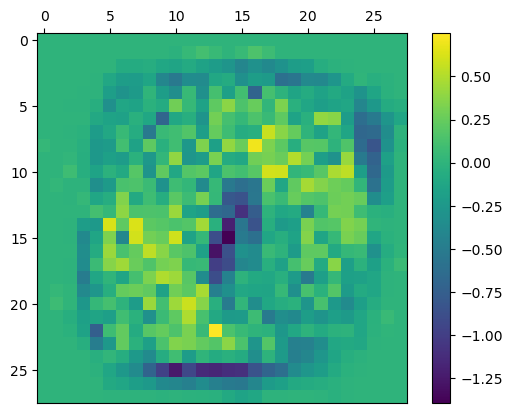

In [32]:
w = model.coef_[0].reshape(28, 28)

fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.xaxis.tick_top()
im = ax.imshow(w)
fig.colorbar(im, ax=ax)
fig.show()

## 確認問題

**(1) 確率的勾配降下法による多クラスロジスティック回帰モデルの学習**

確率的勾配降下法で多クラスロジスティック回帰モデルを学習するアルゴリズムを実装せよ。学習データと評価データはMNISTを用いよ。

In [33]:
class LogisticClassifier():
    
    def __init__(self):
        self.W = None

    def softmax(self, a):
        # refer 6.5.1
        ea = np.exp(a - np.max(a))
        return ea / np.sum(ea)

    def train(self, X, Y, num_class, eta=1e-3, alpha=1e-6, epoch=100000, eps=1e-6):
        N = X.shape[0]
        self.W = np.random.uniform(size=(X.shape[-1], num_class))
        for t in range(epoch):
            i = np.random.choice(N)
            hat_y = self.predict_proba(X[i])
            # to one-hot vector
            y = np.zeros(num_class)
            y[Y[i]] = 1.0
            delta = (y - hat_y) * X[i].reshape((-1, 1)) - 2 * alpha * self.W / N
            if np.sum(np.abs(delta)) < eps:
                break
            self.W += eta * delta
        return self

    def predict_proba(self, x):
        value = x @ self.W
        if len(value.shape) < 2:
            return self.softmax(value).flatten()
        else:
            return np.apply_along_axis(self.softmax, axis=1, arr=value)

    def predict(self, x):
        proba = self.predict_proba(x)
        return np.argmax(proba, axis=1)

softmax関数が実装できているかテストします。

In [34]:
# refer 6.9
np.testing.assert_almost_equal(
    1.0,
    np.sum(LogisticClassifier().softmax(np.array([3, 2, -5])))
)

# refer 6.10
assert np.all((LogisticClassifier().softmax(np.array([3, 2, -5])) > 0) == True)

# refer 6.11
np.testing.assert_almost_equal(
    1.0 / (1 + np.exp(-(0.5 - 0.1))),
    LogisticClassifier().softmax(np.array([0.5, 0.1]))[0]
)

学習を行います。

In [35]:
X_train = data["train_x"]


def to_feature(X):
    return np.c_[X.reshape((X.shape[0], -1)), np.ones(X.shape[0])]


X_train = to_feature(X_train)
model = LogisticClassifier().train(X=X_train, Y=data["train_y"], num_class=10)

**(2) 評価データ上での正解率**

評価データ上で学習したモデルの正解率を測定せよ。

In [36]:
X_test = data["test_x"]
X_test = to_feature(X_test)

In [37]:
from sklearn.metrics import classification_report


predictions = model.predict(X_test)
print(classification_report(data["test_y"], predictions))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.96      0.97      0.96      1135
           2       0.89      0.86      0.88      1032
           3       0.89      0.87      0.88      1010
           4       0.90      0.90      0.90       982
           5       0.86      0.80      0.83       892
           6       0.92      0.93      0.92       958
           7       0.89      0.89      0.89      1028
           8       0.80      0.87      0.83       974
           9       0.86      0.85      0.85      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



正解率であるaccuracyは0.89となります。

---

[機械学習帳](https://chokkan.github.io/mlnote/) © Copyright 2020-2022 by [岡崎 直観 (Naoaki Okazaki)](https://www.chokkan.org/). この作品は<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">クリエイティブ・コモンズ 表示 - 非営利 - 改変禁止 4.0 国際 ライセンス</a>の下に提供されています。 <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/80x15.png" /></a>　ただし、作品中のコードセル部分は<a rel="license" href="https://opensource.org/licenses/MIT">MITライセンス</a>の下に提供されています。